In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
from collections import Counter
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 1000)

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, \
train_test_split, validation_curve
from xgboost.sklearn import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(rc={'figure.figsize':(15,7)}, style='whitegrid')
plt.rcParams['figure.figsize'] = (15,7)

In [2]:
DATA_PATH = 'data/'

TRAIN_FEATURES = os.path.join(DATA_PATH, 'train_new_features.csv')

In [3]:
train_df = pd.read_csv(TRAIN_FEATURES, index_col=0, encoding='utf-8')

In [4]:
train_df.head(2)

,text,target,text_cleaned,preprocessed_text,sentence_count,word_count,stop_word_count,stop_word_share,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count,polarity_raw,subjectivity_raw,unique_word_count,unique_word_share,polarity,subjectivity,DT,NN,PRP$,NNS,VBP,IN,MD,VB,JJ,PRP,JJS,VBN,VBD,TO,VBG,CC,RB,EX,VBZ,CD,WP,RP,JJR,WRB,FW,WDT,NNP,RBR,RBS,PDT,SYM,UH,WP$
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,our deeds are the reason of this earthquake may allah forgive us all,deed reason earthquak may allah forgiv us,1,13,6,0.461538,0,4.384615,69,1,1,0,0.0,0.0,7,1.0,0.0,0.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,forest fire near la rong sask canada,1,7,0,0.000000,0,4.571429,38,1,0,0,0.1,0.4,7,1.0,0.1,0.4,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Data preparation

Check for null values and fill in them.

In [5]:
if train_df.isnull().any().any():
    print('Found missing values in data')
else:
    print('No missing values in data')

Found missing values in data


In [6]:
train_isnull_count = pd.DataFrame(train_df.isnull().sum()).T
train_isnull_count

,text,target,text_cleaned,preprocessed_text,sentence_count,word_count,stop_word_count,stop_word_share,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count,polarity_raw,subjectivity_raw,unique_word_count,unique_word_share,polarity,subjectivity,DT,NN,PRP$,NNS,VBP,IN,MD,VB,JJ,PRP,JJS,VBN,VBD,TO,VBG,CC,RB,EX,VBZ,CD,WP,RP,JJR,WRB,FW,WDT,NNP,RBR,RBS,PDT,SYM,UH,WP$
0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
train_df.fillna('', inplace = True)

In [8]:
if train_df.isnull().any().any():
    print('Found missing values in data')
else:
    print('No missing values in data')

No missing values in data


In [9]:
train = train_df['preprocessed_text']
y = train_df['target']

X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.3, random_state=13, stratify=y)

In [10]:
X_train.shape, X_test.shape

((5264,), (2256,))

## Convert a collection of tweets to a matrix of TF-IDF features

First, we will create a dictionary of all the words using TfidfVectorizer.

Secondly, we are encoding the sentences from the training set texts with the indices of incoming words. We'll use the sparse format.

Third, we will apply the same operations to the test set**

In [11]:
vectorizer = TfidfVectorizer(min_df=5, max_features=20000, ngram_range=(1, 1)) # only unigrams

X_train_tfidf = vectorizer.fit_transform(X_train)

X_test_tfidf = vectorizer.transform(X_test)

### APPROACHES:
 - linear model (Logistic Regression),
 - boosting (XGBoost)

**Define evaluation procedure.**

We will use repeated cross-validation to evaluate the model, with 5-fold cross-validation.

In [12]:
kf = StratifiedKFold(n_splits=5, random_state=13, shuffle=True)

**Define functions for reports with numbers and plots.**

```The leaderboard is based on Mean F-Score which can be implemented with Macro Average F1 Score.```

In [13]:
def plot_cv_with_err(model,
                     data_X,
                     data_y,
                     parameter_name, 
                     params,
                     cv_score,
                     **kwargs):
    
    """Plot results of cv_output_all"""
    
    val_train, val_test = validation_curve(model,
                                           data_X,
                                           data_y,
                                           param_name=parameter_name,
                                           param_range=params,
                                           cv=kf,
                                           scoring=cv_score)
    
    means_train = np.mean(val_train, axis=1)
    stds_train = np.std(val_train, axis=1)
    means_test = np.mean(val_test, axis=1)
    stds_test = np.std(val_test, axis=1)

    lines_train = plt.plot(params, means_train,
                           '-', label='CV training scores on train set', **kwargs)
    lines_test = plt.plot(params, means_test,
                          '-', label='CV validation scores on train set', **kwargs)
    
    plt.fill_between(params, means_train - stds_train, means_train + stds_train,
                     edgecolor='none', facecolor=lines_train[0].get_color(), alpha=0.2)
    plt.fill_between(params, means_test - stds_test, means_test + stds_test,
                     edgecolor='none', facecolor=lines_test[0].get_color(), alpha=0.2)

In [14]:
def cv_output_all(model,
                  data_X,
                  data_y,
                  parameter_name, 
                  params,
                  cv_score):
    
    """Same as plot_cv_with_err"""
    
    val_train, val_test = validation_curve(model,
                                           data_X,
                                           data_y,
                                           param_name=parameter_name,
                                           param_range=params,
                                           cv=kf,
                                           scoring=cv_score)
    means_train = np.mean(val_train, axis=1)
    stds_train = np.std(val_train, axis=1)
    means_test = np.mean(val_test, axis=1)
    stds_test = np.std(val_test, axis=1)
    
    print("                                    CV scores on Train set")
    print("================================================================================================")
    print("  mean_train_score (std_train_score) | mean_valid_score (std_valid_score) |      parameter")
    print("================================================================================================")
    for mean_tr, stdev_tr, mean_te, stdev_te, param \
            in zip(means_train, stds_train, means_test, stds_test, params):
        print("    {:^{width}.{prec}}  ({:^{width}.{prec}}) |   {:^{width}.{prec}}  ({:^{width}.{prec}}) | {:{align}} = {:{align}.{prec}}"
              .format(mean_tr, stdev_tr,
                      mean_te, stdev_te,
                      parameter_name, param,
                      align='<', width='14', prec=5))


## LOGISTIC REGRESSION 

**Define model.**

In [15]:
lr = LogisticRegression(solver='liblinear', penalty='l2', C=1e5,
                        class_weight='balanced', random_state=13)

In [16]:
lr.fit(X_train_tfidf, y_train)

LogisticRegression(C=100000.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=13, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

**Evaluate model, establish a baseline.**

In [17]:
print("f1_score (train set): {:.5}".format(
            f1_score(y_train, lr.predict(X_train_tfidf), average='macro')
))

print("\nf1_score (test set):  {:.5}".format(
            f1_score(y_test, lr.predict(X_test_tfidf), average='macro')
))

f1_score (train set): 0.96496

f1_score (test set):  0.71884


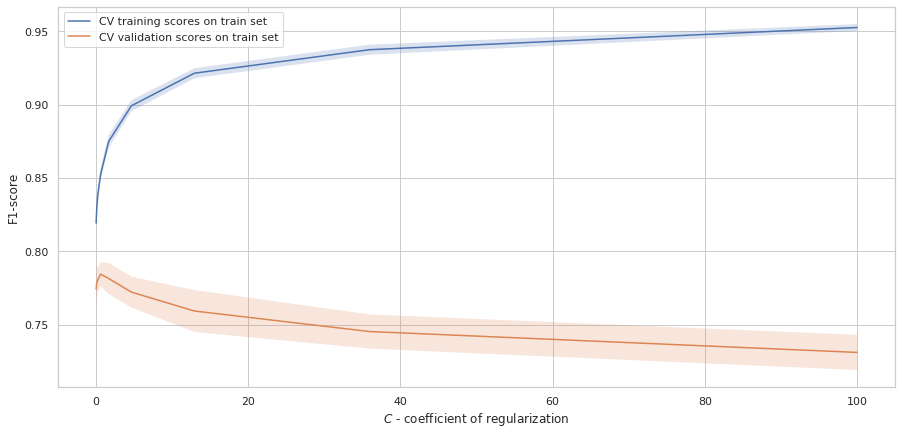

In [18]:
plot_cv_with_err(model = lr,
                 data_X = X_train_tfidf,
                 data_y = y_train,
                 parameter_name = 'C', 
                 params = np.logspace(-2, 2, 10),
                 cv_score = 'f1_macro')

plt.xlabel("$C$ - coefficient of regularization")
plt.ylabel("F1-score")
plt.legend(loc='best')
plt.grid(True)

In [19]:
lr_1 = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=13)

lr_param_grid_1 = {'penalty': ['l1', 'l2'],
                   'C': np.logspace(-2, 2, 10)}

lr_clf_1 = GridSearchCV(estimator=lr_1, cv=kf, param_grid=lr_param_grid_1, scoring='f1_macro', verbose=1)

%time  lr_clf_1.fit(X_train_tfidf, y_train)

print("\nBest_params: {}, best_score: {:.5}".format(lr_clf_1.best_params_, lr_clf_1.best_score_))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CPU times: user 5.27 s, sys: 7.01 ms, total: 5.28 s
Wall time: 5.28 s

Best_params: {'C': 0.5994842503189409, 'penalty': 'l2'}, best_score: 0.78447


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.3s finished


In [20]:
lr_2 = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=13)

lr_param_grid_2 = {'penalty': ['l2'],
                   'C': np.linspace(0.001, 10, 40)}

lr_clf_2 = GridSearchCV(estimator=lr_2, cv=kf, param_grid=lr_param_grid_2, scoring='f1_macro', verbose=1)

%time  lr_clf_2.fit(X_train_tfidf, y_train)

print("\nBest_params: {}, best_score: {:.5}".format(lr_clf_2.best_params_, lr_clf_2.best_score_))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 40 candidates, totalling 200 fits
CPU times: user 3.19 s, sys: 3.46 ms, total: 3.2 s
Wall time: 3.19 s

Best_params: {'C': 0.7701538461538461, 'penalty': 'l2'}, best_score: 0.78487


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    3.2s finished


**Final model.**

In [21]:
lr_final = LogisticRegression(C=1, penalty='l2', solver='liblinear', class_weight='balanced', random_state=13)

%time lr_final.fit(X_train_tfidf, y_train)

CPU times: user 15.3 ms, sys: 0 ns, total: 15.3 ms
Wall time: 14.3 ms


LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=13, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

**Evaluate model.**

In [22]:
print("f1_score (train set): {:.5}".format(
            f1_score(y_train, lr_final.predict(X_train_tfidf), average='macro')
))

print("\nf1_score (test set):  {:.5}".format(
            f1_score(y_test, lr_final.predict(X_test_tfidf), average='macro')
))

f1_score (train set): 0.85758

f1_score (test set):  0.78999


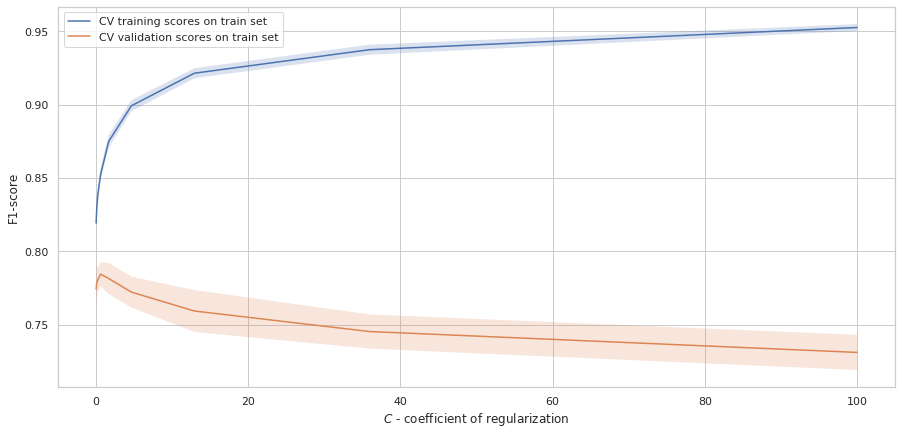

In [23]:
plot_cv_with_err(model = lr_final,
                 data_X = X_train_tfidf,
                 data_y = y_train,
                 parameter_name = 'C', 
                 params = np.logspace(-2, 2, 10),
                 cv_score = 'f1_macro')

plt.xlabel("$C$ - coefficient of regularization")
plt.ylabel("F1-score")
plt.legend(loc='best')
plt.grid(True)

The trend is quite visible.

Training and validation errors differ significantly. This can be explained by **overfitting**. When there are too many parameters or regularization is not strict enough, the algorithm can be "distracted" by the noise in the data and lose track of the overall trend.

Our model tend to be overfitted.

In [24]:
cv_output_all(model = lr_final,
              data_X = X_train_tfidf,
              data_y = y_train,
              parameter_name = 'C', 
              params = np.linspace(0.001, 5, 40),
              cv_score = 'f1_macro'
             )

                                    CV scores on Train set
  mean_train_score (std_train_score) | mean_valid_score (std_valid_score) |      parameter
       0.81222      (  0.0045836   ) |      0.76797      (   0.010147   ) | C = 0.001
       0.83159      (  0.0034191   ) |      0.77979      (   0.011282   ) | C = 0.12918
        0.839       (   0.004083   ) |      0.78099      (   0.008219   ) | C = 0.25736
       0.84476      (  0.0039076   ) |      0.78078      (  0.0087805   ) | C = 0.38554
       0.84921      (  0.0039964   ) |      0.78366      (  0.0084972   ) | C = 0.51372
       0.85325      (  0.0041069   ) |      0.78465      (  0.0078636   ) | C = 0.6419
       0.85725      (  0.0045816   ) |      0.78487      (  0.0086915   ) | C = 0.77008
       0.86044      (  0.0045669   ) |      0.78354      (  0.0091081   ) | C = 0.89826
       0.86397      (   0.005171   ) |      0.78414      (  0.0094493   ) | C = 1.0264
       0.86639      (  0.0052582   ) |      0.78427      (  0.


## XGBoost Classifier

Before any modification or tuning is made to the XGBoost algorithm for imbalanced classification, it is important to test the default XGBoost model and **establish a baseline in performance**.

**Define model.**

In [25]:
xgb = XGBClassifier(objective='binary:logistic', booster='gbtree', random_state=13)

**Fit model (optimize model loss function).**

In [26]:
xgb.fit(X_train_tfidf, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=13, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

**Evaluate model, establish a baseline.**

In [27]:
print("f1_score (train set): {:.5}".format(
            f1_score(y_train, xgb.predict(X_train_tfidf), average='macro')
))

print("\nf1_score (test set):  {:.5}".format(
            f1_score(y_test, xgb.predict(X_test_tfidf), average='macro')
))

f1_score (train set): 0.86301

f1_score (test set):  0.77271


**Imbalanced Classification.**

The *scale_pos_weight* can be used to train a class-weighted or cost-sensitive version of XGBoost for imbalanced classification.

- #### scale_pos_weight = total_negative_examples / total_positive_examples

In [28]:
counter = Counter(y_train)
estimate = counter[0] / counter[1]
print('scale_pos_weight: %.3f' % estimate)

scale_pos_weight: 1.336


**Hyperparameter optimization.**

In [29]:
xgb_1 = XGBClassifier(scale_pos_weight=1.336, learning_rate=0.26,
                      max_depth=7, min_child_weight=1, gamma=0,
                      colsample_bytree=0.9, subsample=0.85,
                      reg_alpha=0.1, reg_lambda=0.01,
                      objective='binary:logistic', booster='gbtree', random_state=13)

xgb_1.fit(X_train_tfidf, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.26, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=13, reg_alpha=0.1,
              reg_lambda=0.01, scale_pos_weight=1.336, subsample=0.85,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [30]:
print("f1_score (train set): {:.5}".format(
            f1_score(y_train, xgb_1.predict(X_train_tfidf), average='macro')
))

print("\nf1_score (test set):  {:.5}".format(
            f1_score(y_test, xgb_1.predict(X_test_tfidf), average='macro')
))

f1_score (train set): 0.89407

f1_score (test set):  0.77927


**Early Stopping to Avoid Overfitting.**

It avoids overfitting by attempting to automatically select the inflection point where **performance on the test dataset starts to decrease** while **performance on the training dataset continues to improve** as the model starts to overfit.

In [31]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train_tfidf, y_train,
                                            test_size=0.33, random_state=7)

xgb_2 = XGBClassifier(scale_pos_weight=1.336, learning_rate=0.26,
                      max_depth=7, min_child_weight=1, gamma=0,
                      colsample_bytree=0.9, subsample=0.85,
                      reg_alpha=0.1, reg_lambda=0.01,
                      objective='binary:logistic', booster='gbtree', random_state=13)

eval_set = [(X_tr, y_tr), (X_val, y_val)]

xgb_2.fit(X_tr, y_tr, eval_metric=['error', 'logloss'], eval_set=eval_set, verbose=True)

[0]	validation_0-error:0.34912	validation_0-logloss:0.66866	validation_1-error:0.35788	validation_1-logloss:0.67441
[1]	validation_0-error:0.32218	validation_0-logloss:0.65155	validation_1-error:0.33775	validation_1-logloss:0.66113
[2]	validation_0-error:0.30601	validation_0-logloss:0.63815	validation_1-error:0.31933	validation_1-logloss:0.64766
[3]	validation_0-error:0.28616	validation_0-logloss:0.62562	validation_1-error:0.29689	validation_1-logloss:0.63890
[4]	validation_0-error:0.25752	validation_0-logloss:0.61345	validation_1-error:0.28136	validation_1-logloss:0.62931
[5]	validation_0-error:0.24702	validation_0-logloss:0.60320	validation_1-error:0.27330	validation_1-logloss:0.61971
[6]	validation_0-error:0.24560	validation_0-logloss:0.59541	validation_1-error:0.27158	validation_1-logloss:0.61488
[7]	validation_0-error:0.23568	validation_0-logloss:0.58595	validation_1-error:0.27273	validation_1-logloss:0.60857
[8]	validation_0-error:0.22717	validation_0-logloss:0.57776	validation_1

[71]	validation_0-error:0.10834	validation_0-logloss:0.35907	validation_1-error:0.22382	validation_1-logloss:0.50520
[72]	validation_0-error:0.10692	validation_0-logloss:0.35714	validation_1-error:0.22324	validation_1-logloss:0.50470
[73]	validation_0-error:0.10579	validation_0-logloss:0.35562	validation_1-error:0.22152	validation_1-logloss:0.50420
[74]	validation_0-error:0.10465	validation_0-logloss:0.35394	validation_1-error:0.22209	validation_1-logloss:0.50529
[75]	validation_0-error:0.10352	validation_0-logloss:0.35208	validation_1-error:0.22209	validation_1-logloss:0.50501
[76]	validation_0-error:0.10210	validation_0-logloss:0.35063	validation_1-error:0.21922	validation_1-logloss:0.50458
[77]	validation_0-error:0.10153	validation_0-logloss:0.34891	validation_1-error:0.21979	validation_1-logloss:0.50473
[78]	validation_0-error:0.09926	validation_0-logloss:0.34666	validation_1-error:0.21979	validation_1-logloss:0.50325
[79]	validation_0-error:0.09841	validation_0-logloss:0.34510	val

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.26, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=13, reg_alpha=0.1,
              reg_lambda=0.01, scale_pos_weight=1.336, subsample=0.85,
              tree_method='exact', validate_parameters=1, verbosity=None)

By default for XGBClassifier *eval_metric = 'error'*.

In [32]:
# make predictions for test data & evaluate predictions

print("f1_score (train set): {:.5}".format(
            f1_score(y_train, xgb_2.predict(X_train_tfidf), average='macro')
))

print("\nf1_score (test set):  {:.5}".format(
            f1_score(y_test, xgb_2.predict(X_test_tfidf), average='macro')
))

f1_score (train set): 0.85994

f1_score (test set):  0.7687


**Plot performance metrics.**

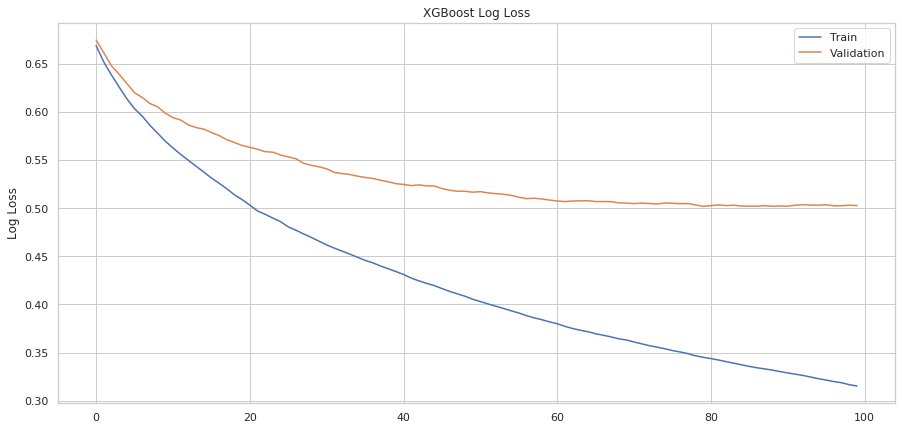

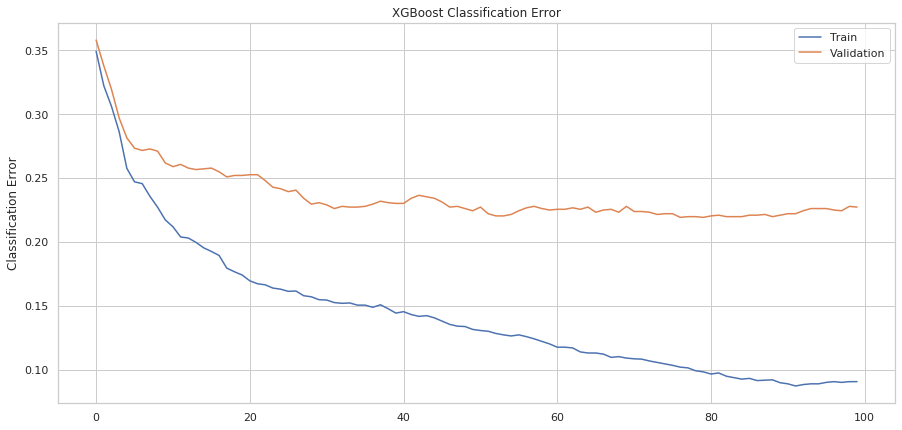

In [33]:
results = xgb_2.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Validation')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Validation')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

The first plot shows the logarithmic loss of the XGBoost model for each epoch on the training and test datasets.

The second plot shows the classification error of the XGBoost model for each epoch on the training and test datasets.

From reviewing the logloss plot, it looks like there is an opportunity to stop the learning early, perhaps somewhere around epoch 80 to epoch 100.

We see a similar story for classification error, where error appears to go back up at around epoch 30.

### Final model.

In [34]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train_tfidf, y_train,
                                            test_size=0.33, random_state=13)

xgb_final = XGBClassifier(scale_pos_weight=1.336, learning_rate=0.26,
                          max_depth=7, min_child_weight=1, gamma=0,
                          colsample_bytree=0.9, subsample=0.85,
                          reg_alpha=0.1, reg_lambda=0.01,
                          objective='binary:logistic', booster='gbtree', random_state=13)

eval_set = [(X_val, y_val)]
xgb_final.fit(X_tr, y_tr, early_stopping_rounds=10, eval_metric='error', eval_set=eval_set, verbose=True)

[0]	validation_0-error:0.36364
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.32796
[2]	validation_0-error:0.31358
[3]	validation_0-error:0.28999
[4]	validation_0-error:0.28769
[5]	validation_0-error:0.27963
[6]	validation_0-error:0.27503
[7]	validation_0-error:0.27158
[8]	validation_0-error:0.26755
[9]	validation_0-error:0.26697
[10]	validation_0-error:0.26985
[11]	validation_0-error:0.26410
[12]	validation_0-error:0.26122
[13]	validation_0-error:0.26352
[14]	validation_0-error:0.26064
[15]	validation_0-error:0.26295
[16]	validation_0-error:0.26525
[17]	validation_0-error:0.26410
[18]	validation_0-error:0.26467
[19]	validation_0-error:0.26697
[20]	validation_0-error:0.26812
[21]	validation_0-error:0.26870
[22]	validation_0-error:0.26467
[23]	validation_0-error:0.26179
[24]	validation_0-error:0.25777
[25]	validation_0-error:0.26064
[26]	validation_0-error:0.26007
[27]	validation_0-error:0.26007
[28]	validation_0-error:0.25604
[29]	validation_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.26, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=13, reg_alpha=0.1,
              reg_lambda=0.01, scale_pos_weight=1.336, subsample=0.85,
              tree_method='exact', validate_parameters=1, verbosity=None)

**Evaluate model.**

In [35]:
print("f1_score (train set): {:.5}".format(
            f1_score(y_train, xgb_final.predict(X_train_tfidf), average='macro')
))

print("\nf1_score (test set):  {:.5}".format(
            f1_score(y_test, xgb_final.predict(X_test_tfidf), average='macro')
))

f1_score (train set): 0.81744

f1_score (test set):  0.76263


We can see that **the model stopped training at epoch 36** (close to what we expected by our manual judgment of learning curves) and that the model with **the best loss was observed at epoch 26**.

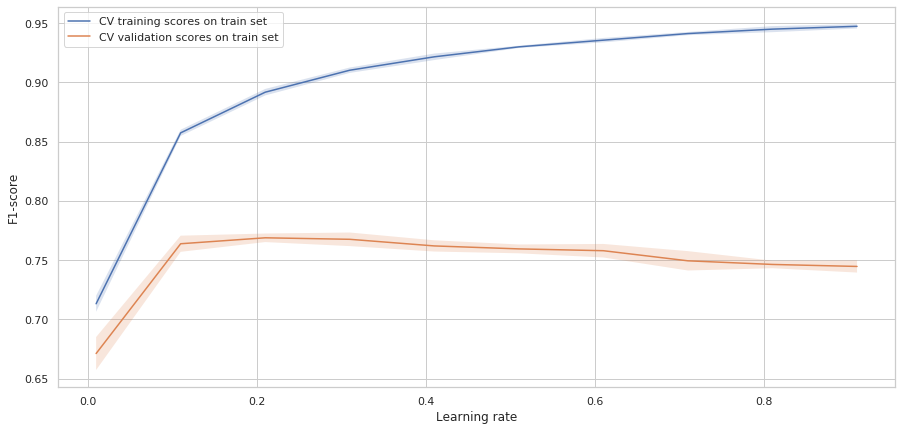

In [36]:
plot_cv_with_err(model = xgb_final,
                 data_X = X_train_tfidf,
                 data_y = y_train,
                 parameter_name = 'learning_rate',
                 params = [i/100.0 for i in range(1,101,10)],
                 cv_score = 'f1_macro')

plt.xlabel("Learning rate")
plt.ylabel("F1-score")
plt.legend(loc='best')
plt.grid(True)

In [37]:
cv_output_all(model = xgb_final,
              data_X = X_train_tfidf,
              data_y = y_train,
              parameter_name = 'learning_rate', 
              params = [i/100.0 for i in range(1,101,10)],
              cv_score = 'f1_macro'
             )

                                    CV scores on Train set
  mean_train_score (std_train_score) | mean_valid_score (std_valid_score) |      parameter
       0.71316      (  0.0067821   ) |      0.67113      (   0.013909   ) | learning_rate = 0.01
       0.85742      (  0.0026365   ) |       0.7638      (  0.0068143   ) | learning_rate = 0.11
       0.89174      (  0.0027421   ) |      0.76883      (  0.0036088   ) | learning_rate = 0.21
       0.91029      (   0.002269   ) |      0.76756      (   0.005736   ) | learning_rate = 0.31
       0.92161      (  0.0027507   ) |      0.76196      (  0.0047396   ) | learning_rate = 0.41
       0.93001      (  0.00097014  ) |      0.75946      (  0.0037264   ) | learning_rate = 0.51
       0.93566      (  0.0018747   ) |      0.75793      (  0.0057136   ) | learning_rate = 0.61
       0.94123      (  0.0013463   ) |      0.74939      (  0.0081738   ) | learning_rate = 0.71
       0.94497      (  0.0025587   ) |      0.74633      (  0.0031948   ) 

## Results

In [38]:
def get_scores(estimator, X, y, name):
    y_pred = estimator.predict(X)
    y_pred_proba = estimator.predict_proba(X)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    columns = ['accuracy', 'precision', 'recall', 'F1-macro', 'AUC-ROC']
    results = pd.DataFrame([accuracy, precision, recall, f1, roc_auc], index=columns, columns=[name]).T

    return results

In [39]:
results_lr = get_scores(lr_final, X = X_test_tfidf, y = y_test, name = 'LR')
results_xgb = get_scores(xgb_final, X = X_test_tfidf, y = y_test, name = 'XGB')

In [40]:
results_lr.append(results_xgb)

,accuracy,precision,recall,F1-macro,AUC-ROC
LR,0.793883,0.754065,0.768912,0.789994,0.867467
XGB,0.772163,0.768772,0.668394,0.762635,0.817116


## CONCLUSIONS

1. Logistic Regression and XGBoost machine learning models with tuned hyperparameters were applied to the TF-IDF matrix obtained from the preprocessed texts.
2. Our data is a sparse matrix thats why Logistic Regression works better then Boosting algorithm.